# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

data_location = '/data/data-with-embeddings/xlm-roberta-base'

processed_amazon_english_data_location = root + data_location + '/amazon_english.json'
processed_amazon_german_data_location = root + data_location + '/amazon_german.json'
processed_organic_data_location = root + data_location + '/organic.json'

embedding_dim = 768

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def read_data(processed_data_location):
  if processed_data_location is None:
    return None

  with open(processed_data_location) as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

In [4]:
amazon_en_df = read_data(processed_amazon_english_data_location)

In [5]:
amazon_de_df = read_data(processed_amazon_german_data_location)

In [6]:
organic_df = read_data(processed_organic_data_location)

In [7]:
sentiment_classes = {'n': 0, '0': 1, 'p': 2}
sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'}

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=1):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]
    if sentiment == 'p' and random.random() > downsampling_factor:
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
  sentiments = torch.Tensor(sentiments).to(device)

  return sentiment_dataset, sentiments

amazon_en_dataset, amazon_en_sentiments = parse_amazon_data(amazon_en_df, 0.15)
amazon_de_dataset, amazon_de_sentiments = parse_amazon_data(amazon_de_df)

In [8]:
organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':last_column].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)
organic_dataset = dataset.DocumentDataset(tuple(organic_embeddings.unsqueeze(1)),
                                          organic_sentiments)

In [9]:
datasets = {'amazon_en' : amazon_en_dataset, 'amazon_de': amazon_de_dataset,
            'organic': organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 4792
len(amazon_de) = 9897
len(organic) = 5084


In [10]:
full_stats = amazon_en_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_en_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1372; after downsampling -> 1372
sentiment "0":
	before downsampling -> 1533; after downsampling -> 1533
sentiment "p":
	before downsampling -> 12605; after downsampling -> 1887


In [11]:
def split(dataset_to_split, splits=(0.8, 0.1, 0.1)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_test = int(splits[2] * n_comments)
  n_train = n_comments - n_val - n_test

  return utils.data.random_split(dataset_to_split, (n_train, n_val, n_test))

amazon_en_train, amazon_en_val, amazon_en_test = split(amazon_en_dataset)
organic_train, organic_val, organic_test = split(organic_dataset)

In [12]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3

milnet = model.MilNet(params, train_embeddings=False).to(device)

In [ ]:
def train(model, train_set, val_set):
  train_loader = utils.data.DataLoader(train_set, batch_size=128,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=128,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-2)
  criterion = nn.NLLLoss()

  nb_epochs = 200
  patience = 50

  return trainer.fit(model, optimizer, criterion, dataloaders, nb_epochs,
                     patience)

print("=====TRAIN ON AMAZON DATA=====")
amazon_en_train_losses, _, amazon_en_val_losses, _ = train(milnet,
                                                           amazon_en_train,
                                                           amazon_en_val)

torch.save(milnet.state_dict(), root + '/models/milnet/state_dicts/roberta_no_finetune')

print("=====FINETUNE ON ORGANIC DATA=====")
organic_train_losses, _, organic_val_losses, _ = train(milnet, organic_train,
                                                       organic_val)

=====TRAIN ON AMAZON DATA=====
Epoch   1/200 -> train loss: 8.39e-03, accuracy: 37.30%
Epoch   1/200 -> val loss: 6.81e-03, accuracy: 30.75%
Epoch   2/200 -> train loss: 8.18e-03, accuracy: 40.15%
Epoch   2/200 -> val loss: 6.70e-03, accuracy: 32.01%
Epoch   3/200 -> train loss: 8.20e-03, accuracy: 37.41%
Epoch   3/200 -> val loss: 6.78e-03, accuracy: 31.17%
Epoch   4/200 -> train loss: 8.14e-03, accuracy: 40.36%
Epoch   4/200 -> val loss: 6.67e-03, accuracy: 32.01%
Epoch   5/200 -> train loss: 8.20e-03, accuracy: 39.16%
Epoch   5/200 -> val loss: 6.74e-03, accuracy: 31.38%
Epoch   6/200 -> train loss: 8.22e-03, accuracy: 38.09%
Epoch   6/200 -> val loss: 6.74e-03, accuracy: 39.12%
Epoch   7/200 -> train loss: 8.12e-03, accuracy: 41.82%
Epoch   7/200 -> val loss: 6.67e-03, accuracy: 33.68%
Epoch   8/200 -> train loss: 8.01e-03, accuracy: 42.22%
Epoch   8/200 -> val loss: 6.61e-03, accuracy: 38.91%
Epoch   9/200 -> train loss: 7.91e-03, accuracy: 43.34%
Epoch   9/200 -> val loss: 6.48e-

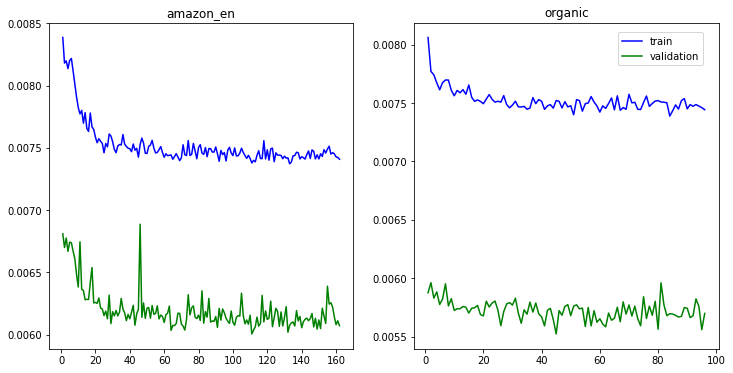

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon_en, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon_en, amazon_en_train_losses,
            amazon_en_val_losses)
plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [16]:
# torch.save(milnet.state_dict(), root + '/models/milnet/state_dicts/roberta')
milnet.load_state_dict(torch.load(root + '/models/milnet/state_dicts/roberta'))

<All keys matched successfully>

In [17]:
def get_results(test_set):
  test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    return (np.argmax(predictions, axis=1), classes.cpu().numpy())

AMAZON_EN = 'amazon_en'
AMAZON_DE = 'amazon_de'
ORGANIC = 'organic'
results = {}


milnet.eval()
with torch.set_grad_enabled(False):
  results[AMAZON_EN] = get_results(amazon_en_test)
  results[ORGANIC] = get_results(organic_test)
  if amazon_de_df is not None:
    results[AMAZON_DE] = get_results(amazon_de_dataset)

In [18]:
for dataset_name, (top1, labels) in results.items():
  print(f'=== {dataset_name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
F1-micro = 0.40501043841336115
F1-macro = 0.35363391291970675

         n    0    p
    n   11  117    8
    0    5  109   23
    p    4  128   74

=== organic ===
F1-micro = 0.531496062992126
F1-macro = 0.4941058050326565

         n    0    p
    n   41  100    7
    0   12  168   16
    p   12   91   61

=== amazon_de ===
F1-micro = 0.35859351318581384
F1-macro = 0.3668958716377373

         n    0    p
    n 1270 2834   38
    0  595 1352   86
    p  328 2467  927

